#**Language Modeling**

Language Modeling aims at defining a probability distribution for the different logical units of a sentence. 

It assigns a conditional probability to each single word, providing a distribution over the whole vocabulary.

**$P(w_{1:n})=\prod_{i=1}^{n}P(w_i|w_{<i})$**

There are two classic approaches for estimating these probabilities, one based on a statistical analysis and the other one on neural models.

In this project we take into account the second one, and specifically we deal with recurrent neural networks.



#**Preparation of the data**

We start by importing the different libraries

In [ ]:
import torch
import torch.utils.data as data
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import pickle
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import math
import timeit
import warnings
import rarfile
warnings.filterwarnings("ignore")
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.nn.utils import weight_norm
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from collections import Counter
from scipy.stats import pearsonr

We set the device we are going to use

In [ ]:
device = 'cuda:0'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
PAD_TOKEN = 0
save='model.tar'

We mount the drive so that to access to our dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
rar_file = rarfile.RarFile("/content/gdrive/MyDrive/dataset/ptbdataset.rar")
rar_file.extractall("/content/gdrive/MyDrive/dataset/")
fold_path = "/content/gdrive/MyDrive/dataset/ptbdataset/"

We set the general parameters of the model, valid for both the regularized and the non-regularized model

In [ ]:
data_txt=str("PTB")
save=str("model.tar")
bptt=60
epochs=100
lr_sgd=0.1
log=100

#**Data pre-processing**

**Dataset**

PTB dataset was developed by researchers at the University of Pennsylvania and consists of approximately $4.5$ million words of newspaper and magazine articles from the Wall Street Journal and Associated Press. It is heavily pre-processed, in that it has no capital letters, numbers (substituted with $N$) or various punctuation. It also contains the token "unk", standing for the large number of out of vocabulary tokens which results for the relatively reduced size of the vocabulary, equal to $10 000$ words.

In [ ]:
def list_sents(path):
    """
    Returns a list of sentences and words from the input text file.
    Each sentence is ending with the special token <eos>.
    The returned list of words also includes the <eos> token.
    
    Parameters
    ----------
    path : str
        The path to the input text file.
        
    Returns
    -------
    sents : list of list of str
        A list of sentences, each one ending with <eos>.
    words : list of str
        A list of words, including the <eos> token.
    """
    sents = []
    words = []
    with open(path) as file:
        for line in file:
          sent = line.split()
          sent.insert(len(sent), '<eos>')
          sents.append(sent)
          for word in line.split():
            words.append(word)
          words.append('<eos>')
    file.close()
    return sents, words


This script is loading data from three different text files, each text file contains sentences which are splitted into words. A vocabulary of unique words is then created.

In [ ]:
# Sentences and words in the training set 
train_data, train_words_list = list_sents(fold_path+"ptb.train.txt")
train_words = set(train_words_list)

# Sentences and words in the test set 
test_data, test_words_list = list_sents(fold_path+"ptb.test.txt")
test_words = set(test_words_list)

# Sentences and words in the validation set 
valid_data, valid_words_list = list_sents(fold_path+"ptb.valid.txt")
valid_words = set(valid_words_list)

The frequency of the lengths of the sentences is visualized using bar plots for training, validation and test sets.

Number of unit lenght sentences in the training set: 137


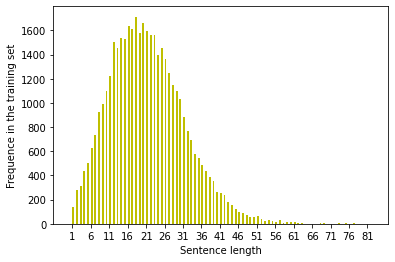

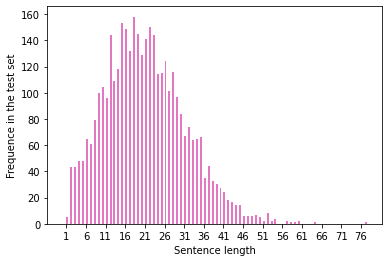

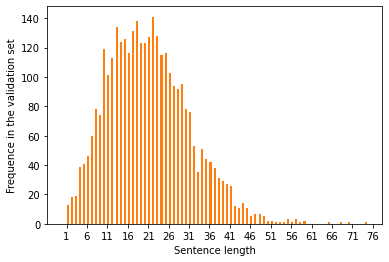

In [ ]:
# Senteces length in training set 
n_words_train = len(max(train_data, key=len))
lengths = list(range(1, n_words_train+1))
frequencies = [0 for i in lengths]
for sent in train_data:
  frequencies[len(sent)-1] += 1

print('Number of unit lenght sentences in the training set: {:d}'.format(frequencies[1]))

pos = np.arange(1.75, n_words_train+3, 5)
lens = list(range(1, n_words_train+3, 5))

ax = plt.axes()
ax.set_xticks(pos)
ax.set_xticklabels(lens)
ax.set_xlabel(r'Sentence length')
ax.set_ylabel(r'Frequence in the training set')

plt.bar(lengths, frequencies, 0.5,color='y')
plt.show()

# Senteces length in test set
n_words_test = len(max(test_data, key=len))
lengths = list(range(1, n_words_test+1))
frequencies = [0 for i in lengths]
for sent in test_data:
  frequencies[len(sent)-1] += 1

pos = np.arange(1.75, n_words_test+3, 5)
lens = list(range(1, n_words_test+3, 5))

ax = plt.axes()
ax.set_xticks(pos)
ax.set_xticklabels(lens)
ax.set_xlabel(r'Sentence length')
ax.set_ylabel(r'Frequence in the test set')

plt.bar(lengths, frequencies, 0.5, color='tab:pink')
plt.show()


# Senteces length in validation set 
n_words_valid = len(max(valid_data, key=len))
lengths = list(range(1, n_words_valid+1))
frequencies = [0 for i in lengths]
for sent in valid_data:
  frequencies[len(sent)-1] += 1

pos = np.arange(1.75, n_words_valid+3, 5)
lens = list(range(1, n_words_valid+3, 5))

ax = plt.axes()
ax.set_xticks(pos)
ax.set_xticklabels(lens)
ax.set_xlabel(r'Sentence length')
ax.set_ylabel(r'Frequence in the validation set')

plt.bar(lengths, frequencies, 0.5, color='tab:orange')
plt.show()

The class called Vocab is used to create a vocabulary of words from a list of words. The class has two methods, the init() method, and the w2id() method.

When an object of the class is created, it takes a list of wordsand an optional argument, cutoff, as inputs. The init() method calls the w2id() method which aims at creating an unique corrispondence between words and integer numbers. There is also the inverse mapping method.

Words that appear less than cutoff times are discarded.

In [ ]:
class Vocab():
    def __init__(self, words, cutoff=0):
        self.word2id = self.w2id(words, cutoff=cutoff)
        self.id2word = {v:k for k, v in self.word2id.items()}
        
    def w2id(self, elements, cutoff=None):
        """
        This function creates a vocabulary of words from a list of words,
        and assigns an id to each word. Words that appear less than 'cutoff' 
        times are discarded.
        """
        vocab = {'pad': PAD_TOKEN, '<eos>': 1}
        count = Counter(elements)
        for k, v in count.items():
          if v > cutoff:
              if k not in vocab:
                vocab[k] = len(vocab)
        return vocab

vocab = Vocab(train_words_list)

This code defines a Pytorch Dataset class called SentsDataset, which is designed to load and manipulate the sentences of the datasets. It takes two arguments, the dataset (a list of sentences) and the vocab (a Vocab object containing the vocabulary of the dataset). The class has three methods init, len, and getitem. The class is then used to create three datasets: train_dataset, valid_dataset, and test_dataset, by passing the corresponding train_data, valid_data, and test_data, and vocab to the class.

In [ ]:
class SentsDataset(data.Dataset):
    """
    A Pytorch Dataset class for loading and manipulating sentence datasets.
    
    Parameters
    ----------
    dataset : list
        A list of sentences
    vocab : Vocab
        A Vocab object containing the vocabulary of the dataset
        
    """
    def __init__(self, dataset, vocab):
        """
        Initialize the SentsDataset class
        
        Parameters
        ----------
        dataset : list
            A list of sentences
        vocab : Vocab
            A Vocab object containing the vocabulary of the dataset
        
        """
        self.dataset = dataset
        self.vocab = vocab

    def __len__(self):
        """
        Return the number of sentences in the dataset
        
        Returns
        -------
        int
            The number of sentences in the dataset
        
        """
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Return the idx-th sentence in the dataset
        
        Parameters
        ----------
        idx : int
            Index of the sentence to be returned
        
        Returns
        -------
        torch.Tensor
            A tensor containing the id's of the words in the sentence
        
        """
        sent = [self.vocab.word2id[word] for word in self.dataset[idx]]
        return torch.Tensor(sent)

# Training dataset
train_dataset = SentsDataset(train_data, vocab)

# Validation dataset
valid_dataset = SentsDataset(valid_data, vocab)

# Test dataset
test_dataset = SentsDataset(test_data, vocab)

Collate_fn is used to merge a batch of sentences into a single tensor.

The function first sorts the sentences in descending order of length, then it splits them into two lists, one for input and one for target. The input list contains all the words except the last one and on the other hand the target list contains all words except the first.

Merge() function is used to take a list of sequences as input and returns a tuple composed by the padded sequences, a tensor of shape (batch_size, max_len), and a list of the lengths of the original sequences.

A matrix full of PAD_TOKEN with the shape batch_size x maximum length of a sequence is created.

The scope is to pad the sequences and create fixed-length inputs and targets, so that all of them will have the same length within a certain batch.

In [ ]:
def collate_fn(data):
    
    """
    A function to merge a batch of sentences into a single tensor.
    
    Parameters
    ----------
    data : list
        A list of sentences
        
    Returns
    -------
    tuple
        A tuple containing:
            - input_pad : torch.Tensor
                A tensor containing the padded inputs of the sentences.
            - target_pad : torch.Tensor
                A tensor containing the padded targets of the sentences.
            - y_lengths : torch.Tensor
                A tensor containing the lengths of the targets.
    """
    
    def merge(sequences):
       
        """
        Merge a list of sequences into a single tensor.
        
        Parameters
        ----------
        sequences : list
            A list of sequences
            
        Returns
        -------
        tuple
            A tuple containing:
                - padded_seqs : torch.Tensor
                    A tensor of shape (batch_size, max_len) containing the padded sequences
                - lengths : list
                    A list of the lengths of the original sequences
        """
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths)==0 else max(lengths)
        
        # Pad token is zero in our case
        # So we create a matrix full of PAD_TOKEN (i.e. 0) with the shape 
        # batch_size X maximum length of a sequence
        padded_seqs = torch.LongTensor(len(sequences),max_len).fill_(PAD_TOKEN)
        for i, seq in enumerate(sequences):
            end = lengths[i]
           
            # We copy each sequence into the matrix
            padded_seqs[i, :end] = seq
       
        # We remove these tensors from the computational graph
        padded_seqs = padded_seqs.detach()
        return padded_seqs, lengths

    # Sort data by seq lengths
    data.sort(key=lambda x: len(x), reverse=True) 

    # Input sequences
    input = [s[:-1] for s in data]
   
    # Target sequences
    target = [s[1:] for s in data]
    input_pad, _ = merge(input)
    target_pad, y_lengths = merge(target)

    y_lengths = torch.LongTensor(y_lengths).to(device)
    
    return (input_pad, target_pad, y_lengths)

Here three Pytorch DataLoader objects are created, respectively for the training, validation and test data. 

The DataLoader class is used to load a dataset in batches. It takes several arguments, such as the dataset, the batch size, the collate function and the shuffle flag. The collate function is used to merge a batch of sentences into a single tensor.

The first line sets the batch size to 64, which means that the DataLoader will return 64 sentences at a time.

The next three lines create the training, validation and test DataLoader objects by passing the corresponding dataset, the batch size, the collate function and the shuffle flag to the DataLoader class.

The training dataloader uses the collate_fn function to collate the data and shuffle the data, so that the model sees different sentences in each iteration. The validation and test dataloader uses the collate_fn function to collate the data but do not shuffle the data, so that the validation and test data are processed in the order they are given.

These DataLoader objects will be used to train, validate and test the model, they will be used to iterate over the data and feed it to the model one batch at a time.

In [ ]:
# Definition of the dataloaders
batch_size = 64

# Training dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn,  shuffle=True)


# Validation dataloader
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Test dataloader
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

#**Functions valid both for the regularized and the no-regularized model**

##**Weights initialization**

The code defines a function called init_weights() which takes a Pytorch model as input. The function loops over all the modules in the model and checks their types. If the module is an LSTM, it loops over all the parameters of the LSTM and assigns different initialization methods to them based on the parameter name. If the parameter name contains weight_ih, it initializes the parameter with the Xavier initialization method. If the parameter name contains weight_hh, it initializes the parameter with the Orthogonal initialization method. If the parameter name contains 'bias', it initializes the parameter with zero.

If the module is not an LSTM, the function checks if it is a Linear or Embedding layer, if it is, it initializes the weights with the uniform initialization method and the biases with zero. Finally, if the module is an Embedding layer, the function also initializes the weights with the uniform initialization method.

The function is used to initialize the weights of a Pytorch model, it is important to initialize the weights of a neural network model before training it, because if the weights are not initialized properly the model may not converge or may take a long time to converge.

In [ ]:
def init_weights(mat):
    
    """
    A function to initialize the weights of a Pytorch model
    
    Parameters
    ----------
    mat : nn.Module
        A Pytorch model
        
    Returns
    -------
    None
    """
    
    for m in mat.modules():
        if type(m) in [nn.LSTM]:
            for name, param in m.named_parameters():
                
                # Xavier initialization for input weights
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
               
                # Orthogonal initialization for recurrent weights
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                
                # Zero initialization for biases
                elif 'bias' in name:
                    param.data.fill_(0.00)
        else:
            
            # Uniform initialization for Linear and Embedding layers
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.1, 0.1)
               
                # Zero initialization for biases
                if m.bias != None:
                    m.bias.data.fill_(0.01)   
            if type(m) in [nn.Embedding]:
                torch.nn.init.uniform_(m.weight, -0.1, 0.1)

##**Optimizers (for the regularized version)**

The traditional SGD has been replaced with a slightly different version of it: Non-monotone Target-Adaptive Stochastic Gradient Descent (NT-ASGD). It is designed specifically to improve the convergence rate of SGD in non-convex optimization problems ad introduces a target update rule that adaptively adjusts the learning rate based on the performance of the current iteration compared to the previous iteration. Taking the average is a method which helps the stabilization of the training and improves the final performance of the model. To ensure that the averaging process does not significantly influence the stability of the neural network weights, it is important to perform averaging at a point during training when the weights have reached a consistent value. One strategy for determining when to average the weights is to monitor the model's performance on a validation set. When the validation metric fails to improve for multiple cycles, averaging can be initiated. This technique requires the use of two additional hyperparameters: L, which represents the logging interval (typically set to the number of iterations in an epoch), and n, a non-monotone interval (commonly set to 5). These hyperparameters are used to help ensure that the randomness of the training process does not significantly impact the decision to average the weights.

In [ ]:
class NTASGD(optim.Optimizer):
    
    """
    A custom Pytorch optimizer called NTASGD (non-monotonically triggered adaptive SGD)
    that inherits from the built-in Pytorch optimizer class optim.Optimizer.
    """
    
    def __init__(self, params, lr=1, n=5, weight_decay=0, fine_tuning=False):
    
        """
        Initializes the optimizer with the given parameters.
        
        Parameters
        ----------
        params : list of torch.Tensor
            The parameters of the model to optimize
        lr : float, optional
            The learning rate of the optimizer, by default 1
        n : int, optional
            The number of previous steps to consider when checking the non-monotonic condition, by default 5
        weight_decay : float, optional
            The weight decay of the optimizer, by default 0
        fine_tuning : bool, optional
            Whether the optimizer is in fine-tuning mode or not, by default False
        """
    
        # Set the default values for the hyperparameters
        self.defaults = dict(
            lr=lr, 
            n=n,  
            weight_decay=weight_decay,  
            fine_tuning=fine_tuning,  
            t0=10e7 if not fine_tuning else 0,  
            t=0,  
            logs=[]  
        )

        # Initialize the optimizer
        super().__init__(params, self.defaults)


    # Check if the current iteration satisfies the non-monotonic condition.
    def check(self, v):
     
        """
        Check if the current iteration satisfies the non-monotonic condition.
        
        Parameters
        ----------
        v : float
            The current iteration's value
            
        Returns
        -------
        bool
            True if the non-monotonic condition is triggered, False otherwise
        """
     
        for group in self.param_groups:
            
            # Check if the current group is in fine-tuning mode or if it is not in fine-tuning mode
            # and the non-monotonic condition has not been triggered yet
            if group["fine_tuning"] or (not group["fine_tuning"] and group["t0"] == 10e7):
            
                # Check if the current iteration is past the n-th iteration and if the current value is
                # greater than the minimum of the last n logs
                if group["t"] > group["n"] and v > min(group["logs"][:-group["n"]]):
                
                    group["t0"] = self.state[next(iter(group["params"]))]["step"]
                
                    print("Non-monotonic condition is triggered!")
                
                    return True
                
                group["logs"].append(v)
                
                group["t"] += 1

    # Set the learning rate for the optimizer
    def lr(self, lr):
   
        """
        Set the learning rate for the optimizer.
        
        Parameters
        ----------
        lr : float
            The new learning rate
        """
      
        for group in self.param_groups:
            group["lr"] = lr


    # Perform a single optimization step
    def step(self):
     
        """
        Perform a single optimization step for all parameters in the groups. 
        """

        for group in self.param_groups:

            for p in group["params"]:

                # Get the gradient of the parameter
                grad = p.grad.data

                # Get the state of the parameter
                state = self.state[p]

                # Initialize the state if it is empty
                if len(state) == 0:

                    state["step"] = 0

                    state["mu"] = 1

                    state["ax"] = torch.zeros_like(p.data)

                # Increment the step counter
                state["step"] += 1

                # Apply weight decay if specified
                if group["weight_decay"] != 0:

                    grad = grad.add(group["weight_decay"], p.data)

                # Update the parameter
                p.data.add_(-group["lr"], grad)

                # Update the moving average parameter
                if state["mu"] != 1:

                    state["ax"].add_(p.data.sub(state["ax"]).mul(state["mu"]))

                else:

                    state["ax"].copy_(p.data)

                state["mu"] = 1 / max(1, state["step"] - group["t0"])

#**Neural Network, baseline**

In this section the baseline of the LSTM is taken into account.

LSTM serves as a fundamental building block for many model languaging tasks.

The specific model we have chosen is composed of three hidden layers.

In init we can find the instantiation of the layers used, while in forward we have the achitecture of the neural 
network.

Let's recall the mathematical formulation of the LSTM


 

*   $i_t = \sigma(W^ix_t +U^ih_{t-1})$
*   $ft = \sigma(W^fx_t +U^fh_{t-1})$
*   $ot =\sigma(W^ox_t +U^oh_{t-1})$
*   $̃c_t = tanh(W^cx_t + U^ch_{t-1})$
*   $c_t=i_t \circ ̃ {c}_t + f_t \circ + ̃ {c}_{t-1}$
*   $h_t = o_t \circ tanh(c_t)$
 

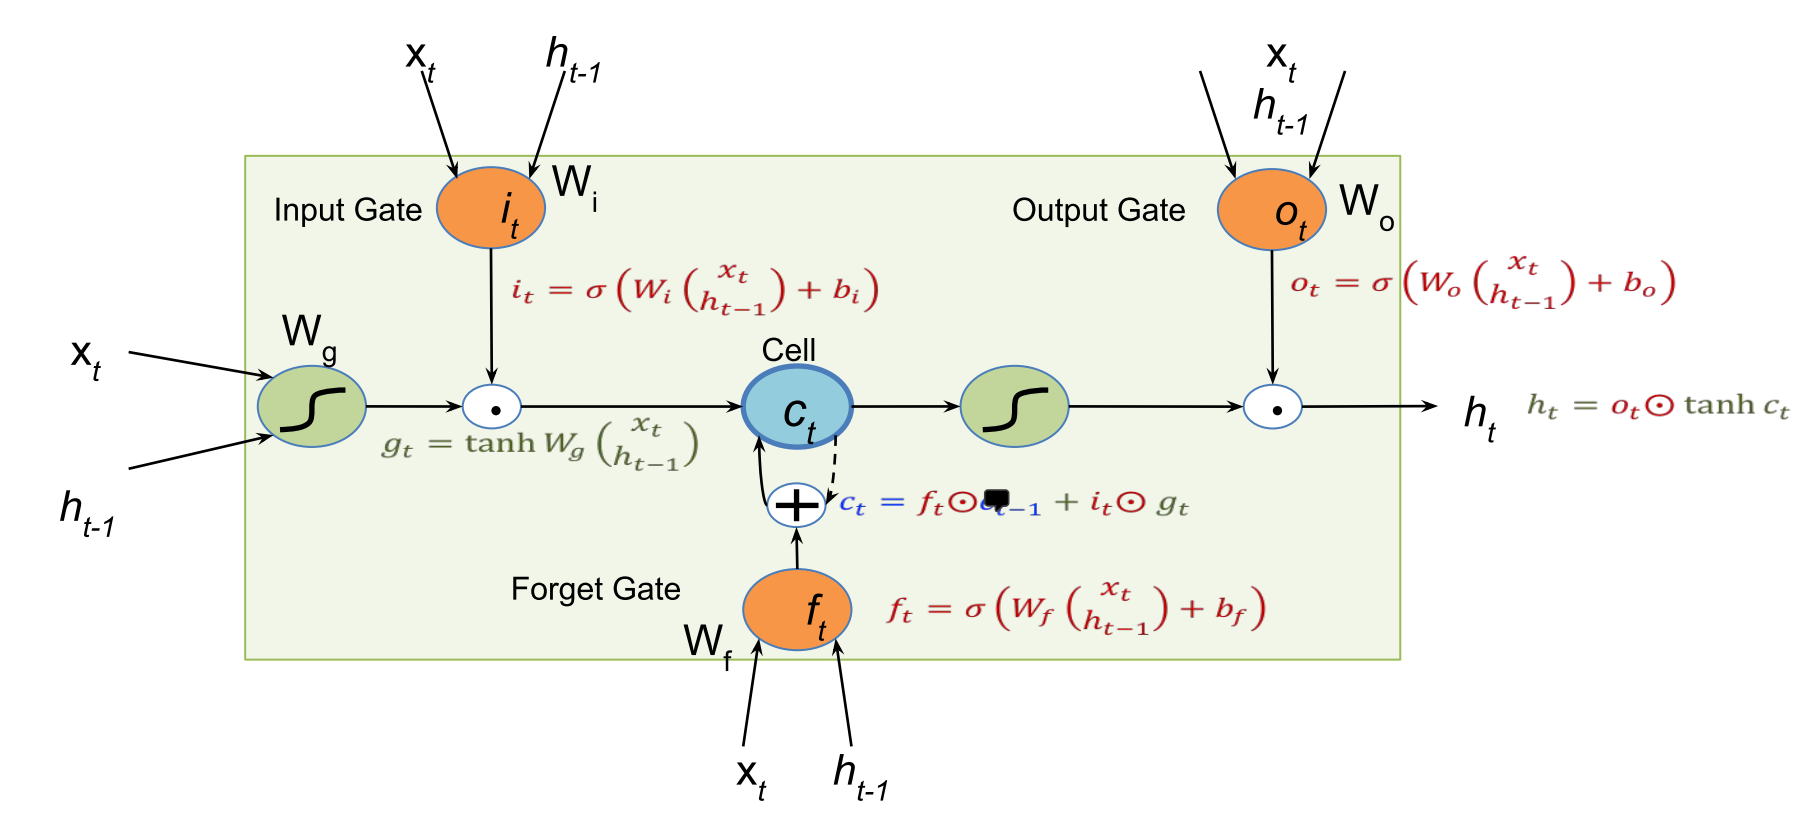

where $[W^i,W^f,W^o, U^i, U^f, U^o]$ are weight matrices, $x_t$ is the vector input to the timestep $t$, $h_t$ is the current exposed hidden state, $c_t$ is the memory cell state, and $\circ$ is element-wise multiplication.

Word embedding is a term used for the representation of words for text analysis. Typically it is in the form of real-valued vectors which encode the meaning of the word such that the words that are closer in the vector space are expected to be similar in meaning.
 


First let's set some parameters of the non-regularized model

In [ ]:
layer_num_reg=1
embed_size_reg=400
hidden_size_reg=400
weight_decay=1.2e-6
lr_reg=0.001
max_grad_norm=0.25
log=float(100)
winit = 0.1
vocab_size = len(vocab.word2id)

This code defines a class called BaseModel that inherits from PyTorch's nn.Module class. The class has an init method that takes in several parameters, including the size of the vocabulary, the size of the embeddings, the size of the hidden layer, and the number of layers in the LSTM. It also has an optional parameter for the index of the padding token in the vocabulary.

The class initializes several layers in the init method, including an embedding layer using PyTorch's nn.Embedding class, an LSTM layer using PyTorch's nn.LSTM class, and a linear output layer using PyTorch's nn.Linear class.

The class also has a forward method that takes in inputs x and seq_lengths and applies the initialized layers to them. The method starts by passing the input x through the embedding layer, permutes the dimensions, and packs the sequence using pack_padded_sequence.

Then it passes the packed sequence through the LSTM layer and gets the output. After that, it pads the output sequence and applies the linear output layer and returns the scores.

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, layer_num, pad_index = PAD_TOKEN):
        super().__init__()

        """
        Initialize the BaseModel with the given parameters
        Parameters:
        vocab_size (int): size of the vocabulary
        embed_size (int): size of the embeddings
        hidden_size (int): size of the hidden layer
        layer_num (int): number of layers in the LSTM
        pad_index (int): index of the padding token in the vocabulary (default: PAD_TOKEN)
        """

        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.vocab_size = vocab_size
        self.layer_num = layer_num
        self.pad_index = pad_index
        
        # Initialize the embedding layer with the given parameters
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=pad_index)
        
        self.rnns = nn.LSTM(embed_size, hidden_size, num_layers = layer_num, bidirectional=False)
        
        # Decoder layer: linear output layer
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, seq_lengths):
        
        x_emb = self.embed(x)
        x_emb = x_emb.permute(1,0,2)

        packed_x = pack_padded_sequence(x_emb, seq_lengths.cpu().numpy())

        packed_y, _ = self.rnns(packed_x)

        padded_y, _ = pad_packed_sequence(packed_y)

        scores = self.fc(padded_y)

        scores = scores.permute(1,0,2).contiguous()

        scores = scores.view(-1, scores.shape[-1])

        return scores

Here the model is instantiated and both the optimizer and the loss criterion are set.

In [ ]:
# Instantiation of model
vocab_size = len(vocab.word2id)
model = BaseModel(vocab_size, embed_size_reg, hidden_size_reg, layer_num_reg, pad_index=PAD_TOKEN).to(device)
model.apply(init_weights)

# Optimizers          
optimizer = torch.optim.SGD(model.parameters(), lr=lr_reg)

# Loss criterion
loss_function = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN, reduction = 'sum')

print(model)

BaseModel(
  (embed): Embedding(10001, 400, padding_idx=0)
  (rnns): LSTM(400, 400)
  (fc): Linear(in_features=400, out_features=10001, bias=True)
)


# **Launch Baseline Model**

BaseTrain is used to train the model on the provided dataset using the SGD optimizer and CE loss function.

In [ ]:
def BaseTrain(data, model, optimizer, loss_predict, tic):
    
    # Set the training data to a local variable
    trn = data
    
    try:
        # Calculate the sequence length and number of batches
        num_batch = len(trn.dataset)// batch_size -1
        
        # Set the model to training mode
        model.train()

        # Cumulative loss values obtained for each batch
        loss_sum_array = []
        
        # Total number of words in the batch
        num_words_array = []

        # Iterate over the training set
        for i, (x, y, length) in enumerate(data):
          if x.size(0) == batch_size:
            
            # Move the input and target data to the specified device
            x = x.to(device)
            y = y.to(device)
            
            # Run the input data and the hidden states through the model
            scores = model(x, length)

            # Zero the gradients of the optimizer
            optimizer.zero_grad()

            # Calculate the cross-entropy loss between the predicted scores and the target data      
            loss = loss_predict(scores, y.reshape(-1))
            loss_sum_array.append(loss.item())
            num_words_array.append((torch.sum(length)).item())
                        
            # Calculate the gradients of the loss with respect to the model's parameters
            loss.backward()
            
            # Perform a single optimization step
            optimizer.step()
            
            # Print training statistics every "log" number of batches
            if i % (log) == 0:
                
                # Calculate the elapsed time
                toc = timeit.default_timer()
                
                # Print the training statistics
                print("batch no = {:d} / {:d}, ".format(i, num_batch) +
                      "train loss = {:.3f}, ".format(loss.item()) +
                      "wps = {:d}, ".format(round(num_words_array[-1]/(toc-tic))) +
                      "since beginning = {:d} mins, ".format(round((toc-tic)/60)) +
                      "cuda memory = {:.3f} GBs".format(torch.cuda.max_memory_allocated()/1024/1024/1024))
    
    except KeyboardInterrupt:
        
        # Print a message if the training is interrupted early
        print("Finishing training early.")
        
    # Return the trained model and the total number of words seen in the epoch
    return model, num_words_array, loss_sum_array

The BaseEvaluate function evaluates the performance of the model on the given dataset. It calculates the loss and returns the results.

In [ ]:
def BaseEvaluate(data_loader, loss_predict, model):
    
    # set the model to evaluation mode
    model.eval()
    
    # Cumulative loss values obtained for each batch
    lossess = []
        
    # Total number of words in the batch
    num_words_array = []
    
    with torch.no_grad():
        # Iterate over the test set
        for i, (x, y, lengths) in enumerate(data_loader):
          if x.size(0) == batch_size:
            # move the minibatch to the device
            x = x.to(device)
            y = y.to(device)
    
            scores = model(x, lengths)

            loss = loss_predict(scores, y.reshape(-1))

            # Update of the loss array
            lossess.append(loss.data.item())
            num_words_array.append((torch.sum(lengths)).item())
    
    return lossess, num_words_array

The model ran for fifty epochs and we can see the values obtained in each epoch.

In [ ]:
# Initialize the best validation perplexity to a large value
best_val = 1e10
epochs = 50

# Vectors filled during training that allow to plot the loss variations across epochs
loss_BaseTrain = []
loss_BaseValid = []
sampled_BaseEpochs = []

# Start a timer
tic = timeit.default_timer() 

# Loop over the number of epochs
for epoch in range(epochs):  

    print("Epoch : {:d}".format(epoch+1))

    # Train the model on the training data and update the total number of words processed
    model, words_train, loss_train = BaseTrain(train_loader, model, optimizer, loss_function, tic)
    
    # Cross entropy
    ce_train = np.asarray(loss_train).sum() / np.asarray(words_train).sum()
    print('CE on the training set: ', ce_train, '\n')

    # Perplexity
    perplexity_train = np.exp(ce_train)
    print('Perplexity on the training set: ', perplexity_train, '\n')

    loss_BaseTrain.append(ce_train)
    sampled_BaseEpochs.append(epoch)
    loss_valid, words_valid = BaseEvaluate(valid_loader, loss_function, model)
    
    # Cross entropy
    ce_valid = np.asarray(loss_valid).sum() / np.asarray(words_valid).sum()
    print('CE on the validation set: ', ce_valid, '\n')

    # Perplexity
    perplexity_valid = np.exp(ce_valid)
    print('Perplexity on the validation set: ', perplexity_valid, '\n')

    loss_BaseValid.append(ce_valid)
    
    if ce_valid < best_val:
 
       # Update the best validation perplexity
        best_val = ce_valid 

        print("CE on the validation set: {:.3f}".format(best_val))

        # Save the model (solo per verificare il calcolo degli errori)
        torch.save({'model_state_dict': model.state_dict()},fold_path+"BaseModel")
        
    print("*************************************************\n")

old_name = fold_path+"BaseModel"
new_name = fold_path+"BaseModel" + "{:.3f}".format(best_val)

os.rename(old_name, new_name)

Epoch : 1
batch no = 0 / 656, train loss = 11585.467, wps = 957, since beginning = 0 mins, cuda memory = 0.523 GBs
batch no = 100 / 656, train loss = 9100.637, wps = 232, since beginning = 0 mins, cuda memory = 0.867 GBs
batch no = 200 / 656, train loss = 9092.630, wps = 123, since beginning = 0 mins, cuda memory = 0.867 GBs
batch no = 300 / 656, train loss = 9245.778, wps = 91, since beginning = 0 mins, cuda memory = 0.867 GBs
batch no = 400 / 656, train loss = 9493.389, wps = 73, since beginning = 0 mins, cuda memory = 0.878 GBs
batch no = 500 / 656, train loss = 8737.149, wps = 57, since beginning = 0 mins, cuda memory = 0.878 GBs
batch no = 600 / 656, train loss = 8227.327, wps = 45, since beginning = 0 mins, cuda memory = 0.878 GBs
CE on the training set:  6.633010323611019 

Perplexity on the training set:  759.7658727215797 

CE on the validation set:  6.242041370032889 

Perplexity on the validation set:  513.9065142555224 

CE on the validation set: 6.242
*********************

Here we plot both the train and the valid loss. The gap between the two already becomes very marked after only ten epochs so the overfitting is more than tangible.

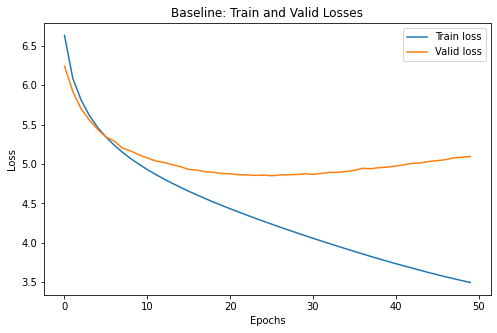

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Baseline: Train and Valid Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')

# Plot train loss over the sampled epochs
plt.plot(sampled_BaseEpochs, loss_BaseTrain, label='Train loss')

# Plot valid loss over the sampled epochs
plt.plot(sampled_BaseEpochs, loss_BaseValid, label='Valid loss')

# Add legend to the plot
plt.legend()

# Show the plot
plt.show()

We perform 4 runs and consider the average result. In this way it should be more reliable.

In [ ]:
runs = 4
loss_runs = []
perp_runs = []

for r in range(1, runs+1):
    model = BaseModel(vocab_size, embed_size_reg, hidden_size_reg, layer_num_reg, pad_index=PAD_TOKEN).to(device)
    model.apply(init_weights)

    # Optimizers   
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_reg)
    # Loss criterion
    loss_function = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN, reduction = 'sum')
    # Start a timer
    tic = timeit.default_timer() 

    n_epochs = 50

    best_val = 1e10

    # Loop over the number of runs
    for x in range(1,n_epochs+1):
        print("Run : {:d},".format(r), end=' ')
        print("Epoch : {:d}".format(x))

        _, words_train, loss_train = BaseTrain(train_loader, model, optimizer, loss_function, tic)

        if x % 4 == 0:
            loss_valid, words_valid = BaseEvaluate(valid_loader, loss_function, model)
            ce_valid = np.asarray(loss_valid).sum() / np.asarray(words_valid).sum()

            if ce_valid < best_val:
              best_val = ce_valid
            else:
              break

    """ Cross entropy loss and perplexity on the test set """
    loss_test, words_test = BaseEvaluate(test_loader, loss_function, model)

    # Cross entropy
    ce_test = np.asarray(loss_test).sum() / np.asarray(words_test).sum()
    loss_runs.append(ce_test)

    # Perplexity
    perplexity_test = np.exp(ce_test)
    perp_runs.append(perplexity_test)

loss_runs = np.asarray(loss_runs)
perp_runs = np.asarray(perp_runs)

# Computation of mean and standard deviation values among the results of the 4 runs
print('Test loss', round(loss_runs.mean(),3), '+-', round(loss_runs.std(),3))
print('Test perplexity', round(perp_runs.mean(), 3), '+-', round(perp_runs.std(), 3))

Run : 1, Epoch : 1
batch no = 0 / 656, train loss = 12831.079, wps = 16393, since beginning = 0 mins, cuda memory = 0.878 GBs
batch no = 100 / 656, train loss = 8616.235, wps = 281, since beginning = 0 mins, cuda memory = 0.926 GBs
batch no = 200 / 656, train loss = 9026.781, wps = 159, since beginning = 0 mins, cuda memory = 0.926 GBs
batch no = 300 / 656, train loss = 7473.620, wps = 89, since beginning = 0 mins, cuda memory = 0.926 GBs
batch no = 400 / 656, train loss = 7345.008, wps = 68, since beginning = 0 mins, cuda memory = 0.937 GBs
batch no = 500 / 656, train loss = 8610.490, wps = 64, since beginning = 0 mins, cuda memory = 0.937 GBs
batch no = 600 / 656, train loss = 7620.543, wps = 47, since beginning = 0 mins, cuda memory = 0.937 GBs
Run : 1, Epoch : 2
batch no = 0 / 656, train loss = 6158.947, wps = 39, since beginning = 1 mins, cuda memory = 0.946 GBs
batch no = 100 / 656, train loss = 7632.782, wps = 40, since beginning = 1 mins, cuda memory = 0.946 GBs
batch no = 200 

#**Neural Network, regularized**

##**Instantiation of model**



In this section we want to try to improve the values of the accuracy gained with perplexity, by adding some regularization tricks.
Let's set again the specific parameters.

In [ ]:
layer_num_reg=1
embed_size_reg=400
hidden_size_reg=400
w_drop=0.5
dropout_i=0.4
dropout_o=0.4
dropout_e=0.1
weight_decay=1.2e-6
lr_reg=0.001
max_grad_norm=0.25
non_mono=5
log=float(100)
regularized = True
winit = 0.1
vocab_size = len(vocab.word2id)

##**Variational Dropout**

Variational dropout is used for all dropout operations except those involving the hidden-to-hidden transition within an RNN, which are regularized with DropConnect. So it is used with reference to the inputs and outputs of the LSTM within a certain forward as well as backward pass. Unlike standard dropout, it uses the same dropout mask at every step, meaning that the same units are dropped at each step. This technique is based on the idea of applying dropout consistently across different layers, rather than randomly selecting units to drop out at each step.


In [ ]:
class VariationalDropout(nn.Module):
   
    """
    A class for implementing Variational Dropout, a dropout technique that is able to learn the dropout rate
    at each step of the training process. 
    """
   
    def __init__(self):
        super().__init__()

    def forward(self, input, dropout):
   
        """
        Applies the dropout operation to the input tensor. 
        :param input: The input tensor
        :param dropout: The dropout rate (probability of setting a value to zero)
        :return: The output tensor after applying dropout
        """
   
        if self.training:
   
            # Generate a mask of 0s and 1s with probability 1-dropout for 1s
            mask = torch.empty(input.size(1), input.size(2), device=input.device).bernoulli_(1 - dropout)
   
            # Scale the mask by the reciprocal of 1-dropout to preserve the expected value of the tensor
            mask = mask / (1 - dropout)
   
            # Apply the mask element-wise to the input tensor
            output = input * mask
        else:
   
            # During evaluation, return the input tensor without applying dropout
            output = input
        return output

    def __repr__(self):
        return "VariationalDropout()"

##**Weight-dropped LSTM**

The weight-dropped LSTM applies regularization through a DropConnect mask on the hidden-to-hidden recurrent weights without affecting the structure of the RNN itself.

This dropout operation is applied to the weight matrices before the forward as well as the backward pass and remain the same for the entirety of these phases as the same weights are reused over multiple steps.

It is used in order to prevent overfitting on the reccurent connections of the LSTMs.

While DropConnect is used to regularize the hidden-to-hidden transition within an RNN, variational dropout is used for all other dropout operations.

In [ ]:
class WeightDropLSTM(nn.Module):
    
    """A PyTorch implementation of the WeightDrop LSTM.
    
    Args:
        input_size (int): The number of features in the input
        hidden_size (int): The number of features in the hidden state
        weight_drop (float, optional): The dropout rate for the weights. Default: 0.0
        
    """
    
    def __init__(self, input_size, hidden_size, weight_drop = 0.0):
        super().__init__()
    
        self.input_size = input_size
    
        self.hidden_size = hidden_size
    
        self.weight_drop = weight_drop
    
        self.module = nn.LSTM(input_size, hidden_size, num_layers = 1, bidirectional = False)
    
        self.weight_name_1 = 'weight_ih_l0'
    
        self.weight_name_2 = 'weight_hh_l0'
        
        # Get the weights for the input and hidden layers
        w1 = getattr(self.module, self.weight_name_1)
        
        w2 = getattr(self.module, self.weight_name_2)
        
        # Create raw parameters for the weights and register them
        self.register_parameter(f'{self.weight_name_1}_raw', nn.Parameter(w1.clone().detach()))
    
        raw_w1 = getattr(self, f'{self.weight_name_1}_raw')
    
        self.register_parameter(f'{self.weight_name_2}_raw', nn.Parameter(w2.clone().detach()))
    
        raw_w2 = getattr(self, f'{self.weight_name_2}_raw')
        
        # Initialize the weights
        self.reset_parameters()
        
        # Apply weight dropout to the input and hidden layer weights
        self.module._parameters[self.weight_name_1] = F.dropout(raw_w1, p=self.weight_drop, training=False)
        
        self.module._parameters[self.weight_name_2] = F.dropout(raw_w2, p=self.weight_drop, training=False)
        
    def reset_parameters(self):
        
        # Initialize the weights with a uniform distribution
        stdv = 1.0 / math.sqrt(self.hidden_size)
        
        for param in self.parameters():
        
            nn.init.uniform_(param, -stdv, stdv)

    def __repr__(self):
        
        # Return a string representation of the model
        return "WeightDropLSTM(input: {}, hidden: {}, weight drop: {})".format(self.input_size, self.hidden_size, self.weight_drop)

    def _setweights(self):
       
        # Set the weights for the input and hidden layers
        raw_w1 = getattr(self, f'{self.weight_name_1}_raw')
       
        self.module._parameters[self.weight_name_1] = F.dropout(raw_w1, p=self.weight_drop, training=self.training)
       
        raw_w2 = getattr(self, f'{self.weight_name_2}_raw')
       
        self.module._parameters[self.weight_name_2] = F.dropout(raw_w2, p=self.weight_drop, training=self.training)

    def forward(self, *args):
        
        # Compute the L2 norm of the row vectors in the embedding matrix
        norm = torch.norm(self.module.weight_ih_l0, dim=1)
        
        # Apply a constraint on the norm of the row vectors
        constraint = torch.clamp(norm, min=0, max=1)
      
        # Normalize the row vectors by dividing by the norm
        self.module._parameters["weight_ih_l0"] = (self.module.weight_ih_l0 / norm.unsqueeze(1)).to(device='cuda')


        # Compute the L2 norm of the row vectors in the projection matrix
        norm = torch.norm(self.module.weight_hh_l0, dim=1)

        # Apply a constraint on the norm of the row vectors
        constraint = torch.clamp(norm, min=0, max=1)

        # Normalize the row vectors by dividing by the norm
        self.module._parameters["weight_hh_l0"] = (self.module.weight_hh_l0 / norm.unsqueeze(1)).to(device='cuda')
     
        # Set the weights for the input and hidden layers
        self._setweights()

        with warnings.catch_warnings():            
            
            # To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")
            
            return self.module.forward(*args)

##**LSTM instantation**

The model is composed of several parts: 

1.   Embed: an embedding layer that maps each word in the vocabulary to a dense vector representation (embedding);
2.   WeightDropLSTM: a variant of the long short-term memory (LSTM) recurrent neural network (RNN) layer that applies dropout to the input-to-hidden and hidden-to-hidden weights;
3.   FC_tied: a fully-connected layer that maps the hidden state to the output. This layer is tied to the embedding layer, meaning that it uses the same weight matrix as the embedding layer;
4.   VariationalDropout: a dropout layer that applies dropout to the input.



In [ ]:
class Model(nn.Module):
    """   
    Args:
        vocab_size (int): The size of the vocabulary
        embed_size (int): The size of the embeddings
        hidden_size (int): The size of the hidden state
        layer_num (int): The number of layers
        w_drop (float): The dropout rate for the weights
        dropout_i (float): The dropout rate for the input
        dropout_o (float): The dropout rate for the output
        dropout_e (float): The dropout rate for the embeddings
        pad_index (int, optional): The index for padding tokens. Default: PAD_TOKEN
    """
    def __init__(self, vocab_size, embed_size, hidden_size, layer_num, w_drop, dropout_i, dropout_o, dropout_e, pad_index = PAD_TOKEN):
        super().__init__()

        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.vocab_size = vocab_size
        self.layer_num = layer_num
        self.pad_index = pad_index
        self.dropout_e = dropout_e
        self.dropout_emb = nn.Dropout(self.dropout_e) 

        # Embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=pad_index)
        
        # LSTM layer
        self.rnns = WeightDropLSTM(embed_size, hidden_size, w_drop) 
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, vocab_size)

        # Share weight between embedding and fc layer
        self.fc.weight = self.embed.weight

        # Variational Dropout
        self.dropout = VariationalDropout()
        
        # Dropout rate for input and output
        self.dropout_i = dropout_i
        self.dropout_o = dropout_o

    def forward(self, x, seq_lengths):
        
        """
        Compute the forward pass of the model
        :param x: input tensor
        :param seq_lengths: sequence lengths of input tensor
        :return: output tensor and input tensor (if in training mode)
        """
        
        x_emb = self.dropout(self.embed(x), self.dropout_i)
        x_emb = x_emb.permute(1,0,2)
        packed_x = pack_padded_sequence(x_emb, seq_lengths.cpu().numpy())

        packed_y, states = self.rnns(packed_x)
        padded_y, _ = pad_packed_sequence(packed_y)
        padded_y = self.dropout(padded_y, self.dropout_o)

        scores = self.fc(padded_y)
        scores = scores.permute(1,0,2).contiguous()
        scores = scores.view(-1, scores.shape[-1])

        if self.training:
            
            return scores, x
       
        else:
       
            return scores

Here the model, the optimizer, and the criterion are set. 

In [ ]:
# Instantiation of model
vocab_size = len(vocab.word2id)
model = Model(vocab_size, embed_size_reg, hidden_size_reg, layer_num_reg, w_drop, dropout_i, dropout_o, dropout_e, pad_index=0).to(device)
model.apply(init_weights)

# Optimizers
lr = 0.001         
optimizer = NTASGD(model.parameters(), lr=lr_reg, n=5, weight_decay=weight_decay, fine_tuning=False)

# Loss criterion
loss_function_reg = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN, reduction = 'sum')

print(model)

Model(
  (dropout_emb): Dropout(p=0.1, inplace=False)
  (embed): Embedding(10001, 400, padding_idx=0)
  (rnns): WeightDropLSTM(input: 400, hidden: 400, weight drop: 0.5)
  (fc): Linear(in_features=400, out_features=10001, bias=True)
  (dropout): VariationalDropout()
)


Early stopping is a technique used to prevent overfitting and it is based on the idea that the model's performance on the validation set will stop improving after a certain number of training epochs, and continuing to train beyond this point will only lead to overfitting.

In this case the monitor is on the perplexity: after three times we see the perplexity increasing we stop the training and get the final value.

There are several benefits to using early stopping:



1.   It can help prevent overfitting by stopping the training process before the model starts to overfit the training data;
2.   It can save time and resources by avoiding the need to train the model for a large number of epochs;
3.   It can improve the generalization ability of the model by avoiding the use of models that are overfitted to the training data.

In [ ]:
class EarlyStopping:
  
  """
    A class for early stopping of training process. 
    
    Args:
        patience (int): Number of epochs to wait before triggering early stopping. Default: 5
        verbose (bool): Flag indicating whether to print messages when early stopping is triggered. Default: True
        
    Attributes:
        patience (int): Number of epochs to wait before triggering early stopping.
        verbose (bool): Flag indicating whether to print messages when early stopping is triggered.
        counter (int): Counter for the number of epochs since the last improvement.
        best_score (float): Best score seen so far. None by default.
  """
  
  def __init__(self, patience=5, verbose=True):
   
    # set the number of epochs to wait before triggering early stopping
    self.patience = patience
   
    # set a flag indicating whether to print messages when early stopping is triggered
    self.verbose = verbose
   
    # initialize the counter for the number of epochs since the last improvement
    self.counter = 0
   
    # initialize the best score seen so far to None
    self.best_score = None

  def step(self, val_loss):
   
    """
        Function to check if early stopping should be triggered.
        
        Args:
            val_loss (float): Current validation loss.
        
        Returns:
            bool: Whether early stopping should be triggered or not.
    """
   
    # if this is the first epoch, set the best score to the current validation loss
    if self.best_score is None:
   
      self.best_score = val_loss
   
    # if the current validation loss is worse than the best score seen so far
    elif val_loss > self.best_score:
   
      # increment the counter
      self.counter += 1
   
      # if the counter has reached the patience threshold
      if self.counter >= self.patience:
   
        # if verbose is True, print a message indicating that early stopping has been triggered
        if self.verbose:
   
          print(f'Early stopping triggered with counter {self.counter} and patience {self.patience}')
   
        # return True to indicate that early stopping should be triggered
        return True
   
    # if the current validation loss is better than the best score seen so far
   
    else:
   
      # set the best score to the current validation loss
      self.best_score = val_loss
   
      # reset the counter
      self.counter = 0
   
    # if the counter has not reached the patience threshold, return False
    return False

##**Training and evaluation loops**

This function is meant for the training of the model.





In [ ]:
def train(data, model, optimizer, loss_predict, tic):
    
    """
    Train the model on the given data
    
    Parameters:
    - data (DataLoader): The data to train on
    - model (nn.Module): The model to train
    - optimizer (Optimizer): The optimizer to use
    - loss_predict (nn.Module): The loss function to use
    - tic (float): The starting time of the training
    """

    trn = data    
    try:
       
        #Calculate the number of batches in the data
        num_batch = len(trn.dataset)// batch_size - 1
        
        #Adjust the learning rate
        optimizer.lr(lr_reg)

        #Set the model to training mode
        model.train()

        # Initialize the lists to store loss and number of words
        loss_sum_array = []
        num_words_array = []

        # Iterate over the batches
        for i, (x, y, length) in enumerate(data):
          if x.size(0) == batch_size:
            # Move the data to the device
            x = x.to(device)
            y = y.to(device)

            # Get the scores and the encoded inputs
            scores, _ = model(x, length)

            # Zero the gradients
            optimizer.zero_grad()

            # Calculate the loss
            loss = loss_predict(scores, y.reshape(-1))
            loss_sum_array.append(loss.item())
            num_words_array.append((torch.sum(length)).item())
                        
            # calculate gradients
            loss.backward()
        
            # optimize
            optimizer.step()
        
            # print out the current status in the given format
            if i % (log) == 0:
                toc = timeit.default_timer()
                print("batch no = {:d} / {:d}, ".format(i, num_batch) +
                      "train loss = {:.3f}, ".format(loss.item()) +
                      "wps = {:d}, ".format(round(num_words_array[-1]/(toc-tic))) +
                      "since beginning = {:d} mins, ".format(round((toc-tic)/60)) +
                      "cuda memory = {:.3f} GBs".format(torch.cuda.max_memory_allocated()/1024/1024/1024))
  
    # in case of early stopping
    except KeyboardInterrupt:
        print("Finishing training early.")

    # return the trained model, num_words_array, and loss_sum_array
    return model, num_words_array, loss_sum_array

Here below the trained model is evaluated.

In [ ]:
def evaluate(data_loader, loss_predict, model):
  
    """
    Evaluate the model on the given data
    
    Parameters:
        data_loader (DataLoader): DataLoader for the evaluation dataset
        loss_predict (function): loss prediction function
        model (nn.Module): the model to evaluate
    
    Returns:
        lossess (list): list of cumulative loss values obtained for each batch
        num_words_array (list): list of total number of words in each batch
    """
    
    # set the model to evaluation mode
    model.eval()
    
    # Cumulative loss values obtained for each batch
    lossess = []
        
    # Total number of words in the batch
    num_words_array = []
    
    with torch.no_grad():

        for i, (x, y, lengths) in enumerate(data_loader):
          if x.size(0) == batch_size:
            x = x.to(device)
            y = y.to(device)
    
            scores = model(x, lengths)

            loss = loss_predict(scores, y.reshape(-1))

            lossess.append(loss.data.item())

            num_words_array.append((torch.sum(lengths)).item())
    
    return lossess, num_words_array

#**Launch Regularized Model**

This code evaluates the performances of the model on the validation and on the test set.

The training loop iterates over 200 epochs (even if we can notice that thanks to Early stopping it exits before).

The perplexity, which is a measure of how well the model is able to predict the next word in a sequence, is calculated and printed.

If the current perplexity is the best seen so far (i.e., it is lower than the current value of best_val), the model is saved and best_val is updated.

In [ ]:
 # Initialize the best validation perplexity to a large value
best_val = 1e10
epochs = 200   

# Vectors filled during training that allow to plot the loss variations across epochs
loss_train_regolarized = []
loss_valid_regolarized = []
sampled_epochs_regolarized = []

# Start a timer
tic = timeit.default_timer() 

regularized = True  

print("Starting training.")

# Create the early stopping criterion
criterion = EarlyStopping(patience=3, verbose=True)

# Loop over the number of epochs
for epoch in range(epochs):  

    print("Epoch : {:d}".format(epoch+1))

    # Train the model on the training data and update the total number of words processed
    model, words_train, loss_train = train(train_loader, model, optimizer, loss_function_reg, tic)
    
    # Cross entropy
    ce_train = np.asarray(loss_train).sum() / np.asarray(words_train).sum()
    print('CE on the training set: ', ce_train, '\n')

    # Perplexity
    perplexity_train = np.exp(ce_train)
    print('Perplexity on the training set: ', perplexity_train, '\n')

    loss_train_regolarized.append(ce_train)
    sampled_epochs_regolarized.append(epoch)

    loss_valid, words_valid = evaluate(valid_loader, loss_function_reg, model)
    
    # Cross entropy
    ce_valid = np.asarray(loss_valid).sum() / np.asarray(words_valid).sum()
    print('CE on the validation set: ', ce_valid, '\n')

    # Perplexity
    perplexity_valid = np.exp(ce_valid)
    print('Perplexity on the validation set: ', perplexity_valid, '\n')

    loss_valid_regolarized.append(ce_valid)
    
    if ce_valid < best_val:
 
       # Update the best validation perplexity
        best_val = ce_valid 

        print("CE on the validation set: {:.3f}".format(best_val)) 
        
        # Save the model
        torch.save({'model_state_dict': model.state_dict()},fold_path+"RegModel")
        
        print("Model saved!")

    # Break the loop if the training is interrupted early
    if criterion.step(ce_valid):
      break


Starting training.
Epoch : 1
batch no = 0 / 656, train loss = 12234.173, wps = 1290, since beginning = 0 mins, cuda memory = 0.524 GBs
batch no = 100 / 656, train loss = 10170.778, wps = 267, since beginning = 0 mins, cuda memory = 0.873 GBs
batch no = 200 / 656, train loss = 8825.595, wps = 130, since beginning = 0 mins, cuda memory = 0.873 GBs
batch no = 300 / 656, train loss = 8266.193, wps = 87, since beginning = 0 mins, cuda memory = 0.873 GBs
batch no = 400 / 656, train loss = 9444.968, wps = 77, since beginning = 0 mins, cuda memory = 0.873 GBs
batch no = 500 / 656, train loss = 8479.716, wps = 57, since beginning = 0 mins, cuda memory = 0.873 GBs
batch no = 600 / 656, train loss = 8413.565, wps = 48, since beginning = 0 mins, cuda memory = 0.873 GBs
CE on the training set:  6.642806638942889 

Perplexity on the training set:  767.2453546552379 

CE on the validation set:  6.215183172904696 

Perplexity on the validation set:  500.2876199347679 

CE on the validation set: 6.215


Train and valid loss are plotted and it is possible to observe that the regularization techniques are really preventing from overfitting.

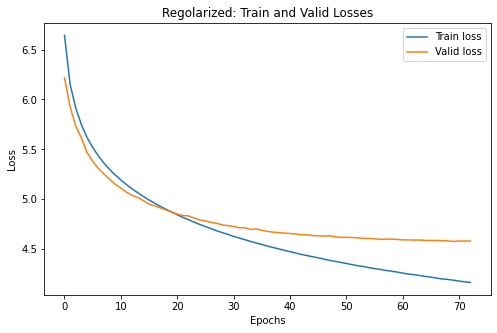

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Regolarized: Train and Valid Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs_regolarized, loss_train_regolarized, label='Train loss')
plt.plot(sampled_epochs_regolarized, loss_valid_regolarized, label='Valid loss')
plt.legend()
plt.show()

Also here we perform 4 runs in order to have more stable results.

In [ ]:
runs = 4
loss_runs = []
perp_runs = []

for r in range(1, runs+1):
    model = Model(vocab_size, embed_size_reg, hidden_size_reg, layer_num_reg, w_drop, dropout_i, dropout_o, dropout_e, pad_index=0).to(device)
    model.apply(init_weights)

    optimizer = NTASGD(model.parameters(), lr=lr_reg, n=5, weight_decay=weight_decay, fine_tuning=False)
    criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN, reduction='sum')
    # Start a timer
    tic = timeit.default_timer() 

    n_epochs = 200

    # Create the early stopping criterion
    criterion = EarlyStopping(patience=2, verbose=True)
    best_val = 1e10

    # Loop over the number of runs
    for x in range(1,n_epochs+1):
        print("Run : {:d},".format(r), end=' ')
        print("Epoch : {:d}".format(x))

        _, words_train, loss_train = train(train_loader, model, optimizer, criterion_slots, tic)

        if x % 5 == 0:
            loss_valid, words_valid = evaluate(valid_loader, criterion_slots, model)
            ce_valid = np.asarray(loss_valid).sum() / np.asarray(words_valid).sum()

            if ce_valid < best_val:
              best_val = ce_valid

            if criterion.step(ce_valid):
              break

    """ Cross entropy loss and perplexity on the test set """
    loss_test, words_test = evaluate(test_loader, criterion_slots, model)

    # Cross entropy
    ce_test = np.asarray(loss_test).sum() / np.asarray(words_test).sum()
    loss_runs.append(ce_test)

    # Perplexity
    perplexity_test = np.exp(ce_test)
    perp_runs.append(perplexity_test)

loss_runs = np.asarray(loss_runs)
perp_runs = np.asarray(perp_runs)

# Computation of mean and standard deviation values among the results of the 4 runs
print('Test loss', round(loss_runs.mean(),3), '+-', round(loss_runs.std(),3))
print('Test perplexity', round(perp_runs.mean(), 3), '+-', round(perp_runs.std(), 3))

Run : 1, Epoch : 1
batch no = 0 / 656, train loss = 11061.963, wps = 1058, since beginning = 0 mins, cuda memory = 0.562 GBs
batch no = 100 / 656, train loss = 8675.430, wps = 223, since beginning = 0 mins, cuda memory = 0.834 GBs
batch no = 200 / 656, train loss = 9237.012, wps = 139, since beginning = 0 mins, cuda memory = 0.873 GBs
batch no = 300 / 656, train loss = 8108.169, wps = 88, since beginning = 0 mins, cuda memory = 0.873 GBs
batch no = 400 / 656, train loss = 7921.439, wps = 65, since beginning = 0 mins, cuda memory = 0.873 GBs
batch no = 500 / 656, train loss = 8333.383, wps = 57, since beginning = 0 mins, cuda memory = 0.873 GBs
batch no = 600 / 656, train loss = 7849.701, wps = 46, since beginning = 0 mins, cuda memory = 0.873 GBs
Run : 1, Epoch : 2
batch no = 0 / 656, train loss = 8259.416, wps = 43, since beginning = 1 mins, cuda memory = 0.873 GBs
batch no = 100 / 656, train loss = 7664.753, wps = 35, since beginning = 1 mins, cuda memory = 0.873 GBs
batch no = 200 /

# **Error Analysis**

Here we will try to draw conclusions about the functioning of the implemented model, attempting to give an explanation for any difficulties encountered.

## **Words with the highest frequency in both the prediction and the target set**

For each example in the test dataset, the model's predictions are obtained, the loss is calculated, and the targets and predictions are converted to lists.

A dictionary is created to store information about the current example, including the first word of the input data, the target and predicted labels, the length of the input data, and the loss. The code then creates a mask to check if the target and prediction match and counts the number of matches. The code also filters out the matching labels from the target and predictions and checks if the predictions are in the set of non-matching targets.

Finally, the code creates a list of dictionaries containing information about each prediction, a list of tuples (target_label, count) and a list of tuples (predicted label, count) as the output.

The information stored in the list of dictionaries includes:

*    The first word of the input data;
*    The target labels of the input data;
*    The predicted labels of the input data;
*    The loss value for the current example;
*    The length of the input data;
*    The number of correct predictions;
*    The number of predictions in the set of non-matching targets.

This list, along with the two lists of tuples, can be used to evaluate the performance of the model on the test dataset. The list of tuples (target_label, count) represents the frequency of each target label in the test dataset, while the list of tuples (predicted_label, count) represents the frequency of each predicted label.

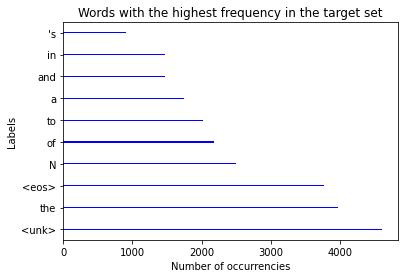

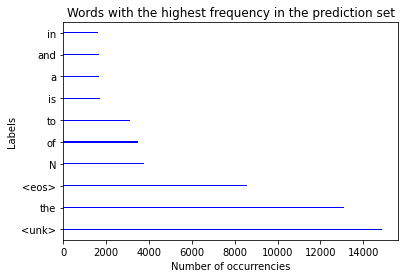

In [ ]:
# Predictions
test_stat = []
target_freq = []
predict_freq = []
field0 = {'1stw': '', 'target': [], 'predict': [], 'loss': 0.0, 'length': 0, 'correct': 0, 'in_set': 0 }

hid_size = 500      
emb_size = 500 

# Load the model's state_dict
checkpoint = torch.load(fold_path+"RegModel")
model.load_state_dict(checkpoint['model_state_dict'])

# set the model to evaluation mode
model.eval()

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size = 1, collate_fn=collate_fn)

# Define the score function (CrossEntropyLoss in this case)
score_function = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)

# Iterate over the test data without keeping track of gradients
with torch.no_grad():

  for i, (inputs, targets, length) in enumerate(test_loader):
      """
        Iterate over the test dataset and make predictions
        
        Parameters:
            inputs (torch.Tensor): the input data
            targets (torch.Tensor): the ground truth labels
            length (torch.Tensor): the length of the input data
        
        Returns:
            test_stat (list): a list of dictionaries containing information about the predictions
            target_freq (list): a list of tuples (target_label, count)
            predict_freq (list): a list of tuples (predicted_label, count)
      """   
      inputs = inputs.to(device)
      targets = targets.to(device)
      length = length.to(device)
        
      # Get the model's predictions
      scores = model(inputs, length)

      predicted_id = scores.argmax(dim=-1) 

      # Calculate the loss
      loss = score_function(scores, targets.view(-1))
      # Convert the targets and predictions to lists
      target_list = targets.reshape(-1).cpu().numpy().tolist()
      predict_list = predicted_id.cpu().numpy().tolist()

      # Create a dictionary to store information about the current example
      field = dict(field0)
      field['1stw'] = inputs[0][0].item()
      field['target'] = list(target_list)
      field['predict'] = list(predict_list)
      field['length'] = length.item()
      field['loss'] = loss.item()

      # Create a mask to check if the target and prediction match
      mask = [1 if x == y else 0 for x, y in zip(target_list, predict_list)]
      field['correct'] = mask.count(1)

      # Filter out the matching labels from the target and predictions
      target_list = list(filter(lambda x_m: x_m[0] if x_m[1] == 0 else None, zip(target_list, mask)))
      predict_list = list(filter(lambda x_m: x_m[0] if x_m[1] == 0 else None, zip(predict_list, mask)))
 
      # Check if the predictions are in the set of non-matching targets
      for s in range(len(predict_list)):
        if predict_list[s] in target_list:
          index = target_list.index(predict_list[s])
          target_list.pop(index)
          field['in_set']+=1
      test_stat.append(field)


  target_words = [f['target'] for f in test_stat]
  target_words = sum(target_words, [])
  target_words = list(set(target_words))

  for w in range(len(target_words)):
      count = sum(t['target'].count(target_words[w]) for t in test_stat)
      target_freq.append((target_words[w], count))
  target_freq = sorted(target_freq, key=lambda x: x[1], reverse=True)

  n_elem = 10
  y = [vocab.id2word[t[0]] for t in target_freq[:n_elem]]
  x = [t[1] for t in target_freq[:n_elem]]
  plt.title('Words with the highest frequency in the target set')
  plt.barh(range(1,n_elem+1), x, 0.05, color='b')
  plt.yticks(range(1,n_elem+1), y)
  plt.ylabel('Labels')
  plt.xlabel('Number of occurrencies')
  plt.show()

  predict_words = [f['predict'] for f in test_stat]
  predict_words = sum(predict_words, [])
  predict_words = list(set(predict_words))

  for w in range(len(predict_words)):
      count = sum(t['predict'].count(predict_words[w]) for t in test_stat)
      predict_freq.append((predict_words[w], count))
  predict_freq = sorted(predict_freq, key=lambda x: x[1], reverse=True)

  n_elem = 10
  y = [vocab.id2word[t[0]] for t in predict_freq[:n_elem]]
  x = [t[1] for t in predict_freq[:n_elem]]
  plt.title('Words with the highest frequency in the prediction set')
  plt.barh(range(1,n_elem+1), x, 0.05, color='b')
  plt.yticks(range(1,n_elem+1), y)
  plt.ylabel('Labels')
  plt.xlabel('Number of occurrencies')
  plt.show()


## **Sentences with the higher and lower values of the loss**

### **Words with the lowest frequency still predicted**

Now we want to observe what is the minimum frequency with which a word in the training set is able to be predicted by the neural network. Output 8 shows that words that appear less than 8 times are not even considered.

In [ ]:
# Initialize count to zero
count = 0

# Create an empty dictionary to store the frequency of words in train_words
train_freq_words = {}

# Iterate through the train_words
for key in train_words:

    # Count the number of occurrences of key in train_words_list
    count = train_words_list.count(key)

    # Add the word and its frequency to the dictionary
    train_freq_words[vocab.word2id[key]] = count

# Initialize min_occur to a large number
min_occur = 1e10

# Iterate through the predict_words
for word in predict_words:

    # Get the number of occurrences of the word in train_words
    occur = train_freq_words[word]

    # Update min_occur if the current word has fewer occurrences than the current min_occur
    if occur < min_occur:
        min_occur = occur

# Print the minimum number of occurrences
print(min_occur)

8


### **Sentences with the lowest values of the loss**

This code prints the first 5 examples with the lowest loss.

It iterates through the range of 5, for each example it prints the loss, the first word of the input data, the target labels, and the predicted labels. It also uses the vocab.id2word[value] to display the actual words from the vocabulary instead of their index values.

In [ ]:
# Sort the test_stat by loss
test_stat = sorted(test_stat, key = lambda x: x['loss'], reverse=True)
sorted_train_freq_words = sorted(train_freq_words.items(), key=lambda item: item[1], reverse=True)


# Print the first 5 examples with the Highest loss
for i in range(5):
    """
    Print the first 5 examples with the Highest loss
    
    Parameters:
        test_stat (list): a list of dictionaries containing information about the predictions
    
    Returns:
        None
    """
   
    print('Loss: {:3f}'.format(test_stat[i]['loss']))
    print('Sent: ' + vocab.id2word[test_stat[i]['1stw']], end=' ')
    for value in test_stat[i]['target']:
        print(vocab.id2word[value], end=' ')
    print('\nTarget :', end=' ')
    for value in test_stat[i]['target']:
        print(vocab.id2word[value], end=' ')
    print('\nPredict:', end=' ')
    for value in test_stat[i]['predict']:
        print(vocab.id2word[value], end=' ')
    for value in test_stat[i]['target']:
        print('\n word: '+ '{:<20}'.format(vocab.id2word[value]), end='')
        print('{:>30}'.format('frequency in training set:' ), end='')
        searched_word = [(key, val) for key, val in sorted_train_freq_words if key == value]
        print(' {:<7}'.format(searched_word[0][1]), end =' ')
        print('\trank: {:d} / {:d}'.format(sorted_train_freq_words.index(searched_word[0]), vocab_size), end='')
    
    print('\n***********************************************************************************')

Loss: 9.236802
Sent: as commonly understood service implies sacrifice <eos> 
Target : commonly understood service implies sacrifice <eos> 
Predict: a as the the the to 
 word: commonly                frequency in training set: 8       	rank: 7240 / 10001
 word: understood              frequency in training set: 16      	rank: 4824 / 10001
 word: service                 frequency in training set: 309     	rank: 336 / 10001
 word: implies                 frequency in training set: 11      	rank: 5909 / 10001
 word: sacrifice               frequency in training set: 7       	rank: 8064 / 10001
 word: <eos>                   frequency in training set: 42068   	rank: 2 / 10001
***********************************************************************************
Loss: 8.834627
Sent: fcc counsel joins firm <eos> 
Target : counsel joins firm <eos> 
Predict: officials <unk> the said 
 word: counsel                 frequency in training set: 35      	rank: 2592 / 10001
 word: joins                

### **Sentences with the highest values of the loss**

This code works as the one above yet for the sentences with the highest value of the loss.

In [ ]:
# Sort the test_stat by loss
test_stat = sorted(test_stat, key = lambda x: x['loss'], )

# Print the first 5 examples with the lowest loss
for i in range(5):
    
    """
    Print the first 5 examples with the lowest loss
    
    Parameters:
        test_stat (list): a list of dictionaries containing information about the predictions
    
    Returns:
        None
    """
    
    print('Loss: {:3f}'.format(test_stat[i]['loss']))
    print('Sent: ' + vocab.id2word[test_stat[i]['1stw']], end=' ')
    for value in test_stat[i]['target']:
        print(vocab.id2word[value], end=' ')
    print('\nTarget :', end=' ')
    for value in test_stat[i]['target']:
        print(vocab.id2word[value], end=' ')
    print('\nPredict:', end=' ')
    for value in test_stat[i]['predict']:
        print(vocab.id2word[value], end=' ')
    for value in test_stat[i]['target']:
        print('\n word: '+ '{:<20}'.format(vocab.id2word[value]), end='')
        print('{:>30}'.format('frequency in training set:' ), end='')
        searched_word = [(key, val) for key, val in sorted_train_freq_words if key == value]
        print(' {:<7}'.format(searched_word[0][1]), end =' ')
        print('\trank: {:d} / {:d}'.format(sorted_train_freq_words.index(searched_word[0]), vocab_size), end='')
    
    print('\n***********************************************************************************')

Loss: 0.167244
Sent: revenue rose N N to $ N billion from $ N billion <eos> 
Target : rose N N to $ N billion from $ N billion <eos> 
Predict: rose N N to $ N billion from $ N billion <eos> 
 word: rose                    frequency in training set: 747     	rank: 119 / 10001
 word: N                       frequency in training set: 32481   	rank: 3 / 10001
 word: N                       frequency in training set: 32481   	rank: 3 / 10001
 word: to                      frequency in training set: 23638   	rank: 5 / 10001
 word: $                       frequency in training set: 7541    	rank: 12 / 10001
 word: N                       frequency in training set: 32481   	rank: 3 / 10001
 word: billion                 frequency in training set: 1881    	rank: 48 / 10001
 word: from                    frequency in training set: 4724    	rank: 20 / 10001
 word: $                       frequency in training set: 7541    	rank: 12 / 10001
 word: N                       frequency in training set

## **Correlation between lenght and correctness**

Here we want to try to relate the length of the predicted sentence to the actual correctness of the prediction. As can be seen, the two variables are inversely correlated (negative correlation index), but since the value is small they do not particularly affect each other.


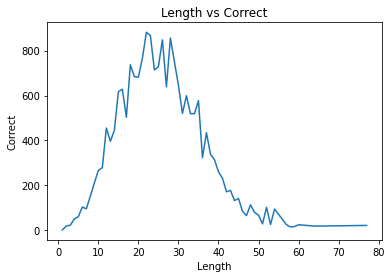

In [ ]:
# Sort the test_stat by length
test_stat = sorted(test_stat, key = lambda x: x['length'])

# Create a dictionary to store the number of correct predictions per length
length_correct_map = {}

# Iterate through the test_stat and add the correct predictions to the dictionary
for field in test_stat:
    length = field['length']
    correct = field['correct']
    if length not in length_correct_map:
        length_correct_map[length] = []
    length_correct_map[length].append(correct)

# Create lists for lengths and correct predictions
lengths = []
corrects = []

# Iterate through the dictionary and add the values to the lists
for length, correct_list in length_correct_map.items():
    correct = sum(correct_list)
    lengths.append(length)
    corrects.append(correct)

# Plot the lengths and correct predictions
plt.plot(lengths, corrects)
plt.xlabel('Length')
plt.ylabel('Correct')
plt.title('Length vs Correct')
plt.show()

## **Correlation between lenght and correctness**

Here the purpose is actually the same one of the code just described, yet in this case ww do not care that the word is located in the right position within the sentence. We only observe whether the word is actually contained in it.

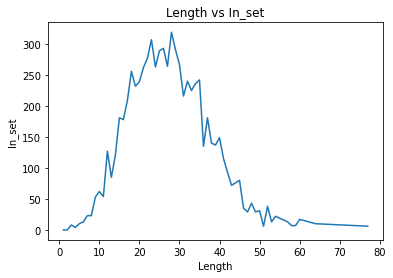

In [ ]:
# Sort the test_stat by length
test_stat = sorted(test_stat, key = lambda x: x['length'])

# Create a dictionary to store the number of correct predictions per length
length_in_set_map = {}

# Iterate through the test_stat and add the in_set to the dictionary
for field in test_stat:
    length = field['length']
    in_set = field['in_set']
    if length not in length_in_set_map:
        length_in_set_map[length] = []
    length_in_set_map[length].append(in_set)

# Create lists for lengths and in_set
lengths = []
in_sets = []

# Iterate through the dictionary and add the values to the lists
for length, in_set_list in length_in_set_map.items():
    in_set = sum(in_set_list)
    lengths.append(length)
    in_sets.append(in_set)

# Plot the lengths and in_set
plt.plot(lengths, in_sets)
plt.xlabel('Length')
plt.ylabel('In_set')
plt.title('Length vs In_set')
plt.show()

## **Correlation between the lenght and the loss**

Now we correlate length with loss. Here the correlation index is positive (direct proportionality) but still has a very small value, which is why it can be inferred that these two variables do not particularly influence each other either.

Correlation ratio:  0.13489228987756366


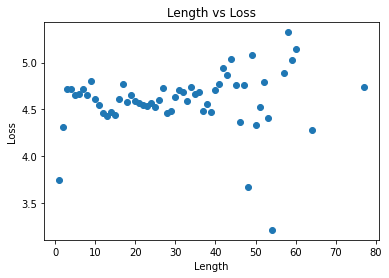

In [ ]:
# Sort the test_stat by length
test_stat = sorted(test_stat, key = lambda x: x['length'])

# Create a dictionary to store the losses per length
length_loss_map = {}

# Iterate through the test_stat and add the loss to the dictionary
for field in test_stat:
    length = field['length']
    loss = field['loss']
    if length not in length_loss_map:
        length_loss_map[length] = []
    length_loss_map[length].append(loss)

# Create lists for lengths and losses
lengths = []
losses = []

# Iterate through the dictionary and calculate the average loss per length
for length, loss_list in length_loss_map.items():
    avg_loss = sum(loss_list) / len(loss_list)
    lengths.append(length)
    losses.append(avg_loss)
    
# Calculate the correlation coefficient 
correlation, _ = pearsonr(lengths, losses)
print('Correlation ratio: ', correlation)

# Plot the scatterplot of lengths and losses
plt.scatter(lengths, losses)
plt.xlabel('Length')
plt.ylabel('Loss')
plt.title('Length vs Loss')
plt.show()
